# Autoencoders Illustrated on MNIST

Herman Kamper, Stellenbosch University, 2018.

## Overview

Different types of autoencoders are applied to MNIST.  They aim of this Notebook is to give succinct implementations of several different autoencoder models.  Intermediate representations from the models are also visualised.  The models here are not tuned, the only purpose is to illustrate the models.

The Notebook was developed and tested using Python 2.7 and TensorFlow 1.3.  The code relies on utility functions in the separate `training.py` and `plotting.py` modules.

The following models are considered:

- [Autoencoder](#Autoencoder)
- [Variational autoencoder](#Variational-autoencoder)
- [Vector-quantised variational autoencoder](#Vector-quantised-variational-autoencoder)
- [Categorical VAE using the Gumbel-Softmax trick](#Categorical-VAE-using-the-Gumbel-Softmax-trick)

## Preamble

In [1]:
%matplotlib inline
from __future__ import division
from __future__ import print_function

In [2]:
from os import path
from sklearn import manifold, preprocessing
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image
import sys
import tensorflow as tf

In [3]:
from training import train_fixed_epochs
import plotting

In [4]:
output_dir = "/tmp/data-kamperh/"

## Data

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(output_dir, one_hot=True)

Extracting /tmp/data-kamperh/train-images-idx3-ubyte.gz
Extracting /tmp/data-kamperh/train-labels-idx1-ubyte.gz
Extracting /tmp/data-kamperh/t10k-images-idx3-ubyte.gz
Extracting /tmp/data-kamperh/t10k-labels-idx1-ubyte.gz


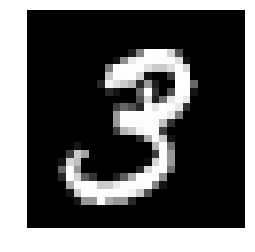

In [6]:
plt.imshow(np.reshape(mnist.train.images[1, :], (28, 28)), cmap="gray")
plt.axis("off");

## Utility functions

In [7]:
# Neural network functions

TF_DTYPE = tf.float32

def build_linear(x, n_output):
    n_input = x.get_shape().as_list()[-1]
    W = tf.get_variable(
        "W", [n_input, n_output], dtype=TF_DTYPE,
        initializer=tf.contrib.layers.xavier_initializer()
        )
    b = tf.get_variable(
        "b", [n_output], dtype=TF_DTYPE,
        initializer=tf.random_normal_initializer()
        )
    return tf.matmul(x, W) + b

In [8]:
def plot_labelled_2d_data(X, labels):
    classes = set(labels)
    for label in sorted(classes):
        indices = np.where(np.array(labels) == label)[0]
        plt.scatter(X[indices, 0], X[indices, 1], label=label)

## Autoencoder

$\renewcommand{\vec}[1]{\boldsymbol{\mathbf{#1}}}$A standard autoencoder is trained with the reconstruction loss:

$$\ell(\vec{x}^{(i)}; \vec{\theta}) = \left|\left|\vec{f}(\vec{x}^{(i)}) - \vec{x}^{(i)}\right|\right|^2$$

where $\vec{f}(\vec{x}^{(i)})$ is the output of the neural network for the single training example $\vec{x}^{(i)}$.

In [9]:
def build_autoencoder(x, enc_n_hiddens, n_z, dec_n_hiddens,
        activation=tf.nn.relu):
    """
    Build an autoencoder with the number of encoder and decoder units.
    
    The number of encoder and decoder units are given as lists. The middle
    (encoding/latent) layer has dimensionality `n_z`. This layer and the final
    layer are linear.
    """

    # Encoder
    for i_layer, n_hidden in enumerate(enc_n_hiddens):
        with tf.variable_scope("ae_enc_{}".format(i_layer)):
            x = build_linear(x, n_hidden)
            x = activation(x)

    # Latent variable
    with tf.variable_scope("ae_latent"):
        x = build_linear(x, n_z)
        z = x

    # Decoder
    for i_layer, n_hidden in enumerate(dec_n_hiddens):
        with tf.variable_scope("ae_dec_{}".format(i_layer)):
            x = build_linear(x, n_hidden)
            if i_layer != len(dec_n_hiddens) - 1:
                x = activation(x)
    y = x
    
    return {"z": z, "y": y}

In [10]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 25
batch_size = 100
enc_n_hiddens = [500, 500]
n_z = 20
dec_n_hiddens = [500, 500, 28*28]

# Model
x = tf.placeholder(TF_DTYPE, [None, 28*28])
ae = build_autoencoder(x, enc_n_hiddens, n_z, dec_n_hiddens)
z = ae["z"]
y = ae["y"]
model_fn = path.join(output_dir, "ae.ckpt")

# Standard reconstruction loss
loss = tf.losses.mean_squared_error(x, y)

# Log loss
# y = tf.sigmoid(y)
# loss = tf.reduce_mean(
#     -tf.reduce_sum(x*tf.log(1e-10 + y) + (1 - x)*tf.log(1e-10 + 1 - y), 1)
#     )

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [11]:
# Train model

class MNISTTrainFeedIterator(object):
    def __iter__(self):
        n_batches = int(mnist.train.num_examples/batch_size)
        for i_batch in xrange(n_batches):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            yield [batch_x]


class MNISTTestFeedIterator(object):
    def __iter__(self):
        yield [mnist.validation.images]


record_dict = train_fixed_epochs(
    n_epochs, optimizer, loss, MNISTTrainFeedIterator(),
    [x], loss, MNISTTestFeedIterator(),
    save_model_fn=model_fn
    )

2018-06-05 17:43:29.254033
Epoch 0:
0.942 sec, train loss: 0.0461435, val loss: 0.0238925
Epoch 1:
0.782 sec, train loss: 0.0221112, val loss: 0.0203215
Epoch 2:
0.818 sec, train loss: 0.0195515, val loss: 0.0185138
Epoch 3:
0.830 sec, train loss: 0.0179799, val loss: 0.0171347
Epoch 4:
0.776 sec, train loss: 0.0168287, val loss: 0.0162615
Epoch 5:
0.789 sec, train loss: 0.0159381, val loss: 0.015446
Epoch 6:
0.774 sec, train loss: 0.0152335, val loss: 0.0147576
Epoch 7:
0.777 sec, train loss: 0.0146781, val loss: 0.0143978
Epoch 8:
0.785 sec, train loss: 0.0141636, val loss: 0.0137209
Epoch 9:
0.779 sec, train loss: 0.0137735, val loss: 0.0135287
Epoch 10:
0.845 sec, train loss: 0.0134107, val loss: 0.0131588
Epoch 11:
0.781 sec, train loss: 0.0131231, val loss: 0.0127732
Epoch 12:
0.777 sec, train loss: 0.0128385, val loss: 0.0126966
Epoch 13:
0.777 sec, train loss: 0.0125904, val loss: 0.0124435
Epoch 14:
0.790 sec, train loss: 0.0123627, val loss: 0.0121227
Epoch 15:
0.787 sec, tra

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/ae.ckpt


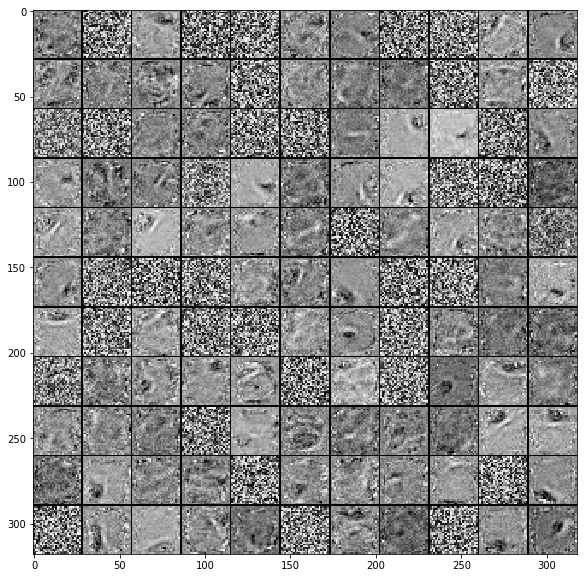

In [12]:
# Plot weights from first layer

# Obtain weight matrix
with tf.variable_scope("ae_enc_0", reuse=True):
    W_0 = tf.get_variable("W", dtype=TF_DTYPE)
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    W_0 = W_0.eval()

# Plot weights
W_0 = np.transpose(W_0)
image = Image.fromarray(
    plotting.tile_images(W_0, image_shape=(28, 28), tile_shape=(11, 11))
    )
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap="gray");

In [13]:
# Embed test data
n_test = 1000
x_np = mnist.test.images[:n_test, :]
test_labels = mnist.test.labels[:n_test]
test_labels = np.argmax(test_labels, axis=1)  # convert from one-hot
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    z_np = session.run([z], feed_dict={x: x_np})[0]
    y_np = session.run([y], feed_dict={x: x_np})[0]

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/ae.ckpt


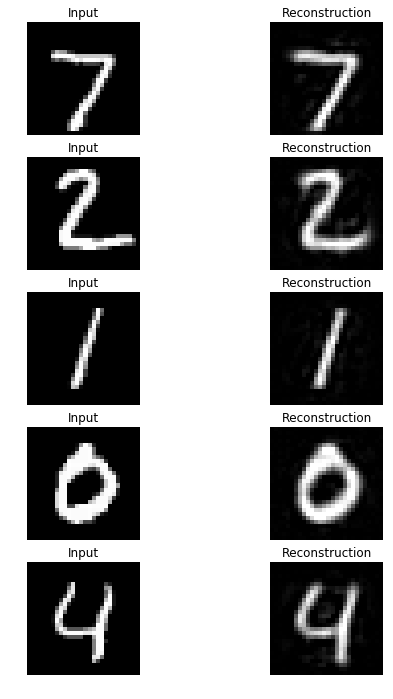

In [14]:
# Plot reconstruction
plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.title("Input")
    plt.imshow(x_np[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    plt.subplot(5, 2, 2*i + 2)
    plt.title("Reconstruction")
    plt.imshow(y_np[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")

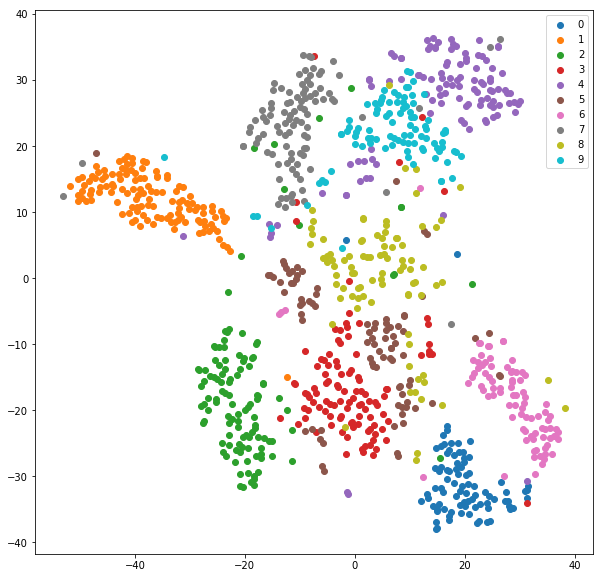

In [15]:
# Plot t-SNE embeddings of the latent variables
tsne = manifold.TSNE(
    n_components=2, #perplexity=20, init="random",
    random_state=0
    )
z_tsne = tsne.fit_transform(z_np)
plt.figure(figsize=(10, 10))
plot_labelled_2d_data(z_tsne, test_labels)
plt.legend();

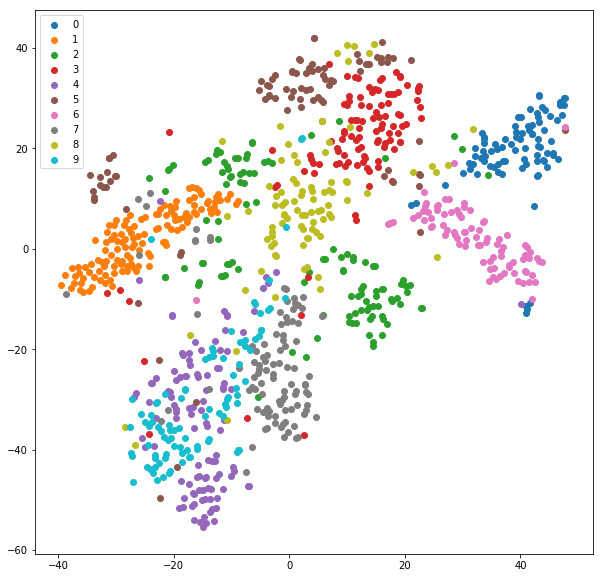

In [16]:
# Plot t-SNE embeddings of the original data
tsne = manifold.TSNE(
    n_components=2,
    random_state=0
    )
x_tsne = tsne.fit_transform(x_np)
plt.figure(figsize=(10, 10))
plot_labelled_2d_data(x_tsne, test_labels)
plt.legend();

/r2d2/tools/py2.7_tf1.0/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/r2d2/tools/py2.7_tf1.0/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


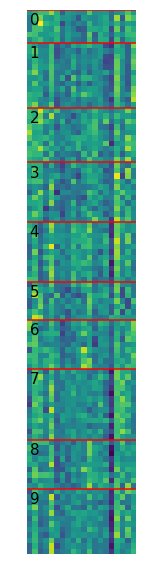

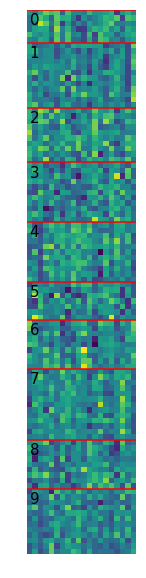

In [17]:
# Plot the embeddings themselves

# Get random indices
n_plot = 100
indices = np.arange(len(test_labels))
np.random.seed(1)
np.random.shuffle(indices)
indices = indices[:n_plot]

# Plot embeddings directly
indices_sorted = np.argsort(test_labels[indices], axis=0)
z_sorted = z_np[indices][indices_sorted, :]
labels_sorted = test_labels[indices][indices_sorted]
plt.figure(figsize=(10, 10))
plt.imshow(z_sorted)
ax = plt.gca()
for i, label in enumerate(labels_sorted):
    if labels_sorted[i] != labels_sorted[i - 1]:
        plt.axhline(y = i - 0.5, color="r")
        ax.text(0, i, str(label), verticalalignment="top", fontsize=15)
plt.axis('off');

# Plot mean and variance normalised embeddings
plt.figure(figsize=(10, 10))
plt.imshow(preprocessing.scale(z_sorted))
ax = plt.gca()
for i, label in enumerate(labels_sorted):
    if labels_sorted[i] != labels_sorted[i - 1]:
        plt.axhline(y = i - 0.5, color="r")
        ax.text(0, i, str(label), verticalalignment="top", fontsize=15)
plt.axis('off');

## Variational autoencoder

_Resources:_ https://arxiv.org/abs/1312.6114; https://arxiv.org/abs/1606.05908; https://jmetzen.github.io/2015-11-27/vae.html

The variational autoencoder (VAE) is trained by minimising the negative of the evidence lower bound (ELBO), i.e. maximising the ELBO:

$$\ell(\vec{x}^{(i)}; \vec{\theta}, \vec{\phi}) = -J(\vec{x}^{(i)}; \vec{\theta}, \vec{\phi})$$

with the ELBO given by

$$J(\vec{x}^{(i)}; \vec{\theta}, \vec{\phi}) = \mathbb{E}_{q_{\phi}(\vec{z}|\vec{x}^{(i)})} \left[ \log p_{\theta}(\vec{x}^{(i)}|\vec{z}) \right] - D_{\textrm{KL}} \left( q_{\phi}(\vec{z}|\vec{x}^{(i)}) || p(\vec{z}) \right)$$

The ELBO is a lower bound:

$$ \log p_\theta(\vec{x}^{(i)}) \geq \mathbb{E}_{q_{\phi}(\vec{z}|\vec{x}^{(i)})} \left[ \log p_{\theta}(\vec{x}^{(i)}|\vec{z}) \right] - D_{\textrm{KL}} \left( q_{\phi}(\vec{z}|\vec{x}^{(i)}) || p(\vec{z}) \right)$$

The first term is normally approximated with a single Monte Carlo sample:

$$\mathbb{E}_{q_{\phi}(\vec{z}|\vec{x}^{(i)})} \left[ \log p_{\theta}(\vec{x}^{(i)}|\vec{z}) \right] \approx \log p_{\theta}(\vec{x}^{(i)}|\vec{z}^{(l)}) \textrm{ with } \vec{z}^{(l)} \sim q_{\phi}(\vec{z}|\vec{x}^{(i)})$$

Assuming a spherical Gaussian distribution for the decoder $p_{\theta}(\vec{x}^{(i)}|\vec{z})$, with covariance $\sigma^2\vec{I}$, this reduces to

$$\log p_{\theta}(\vec{x}^{(i)}|\vec{z}^{(l)}) = c - \frac{1}{2\sigma^2} \left|\left| \vec{f} (\vec{z}^{(l)}) - \vec{x}^{(i)} \right|\right|^2 $$

with $c$ a constant (from the normalisation) and $\vec{f} (\vec{z}^{(l)})$ the output of the network given the (sampled) latent variable $\vec{z}^{(l)}$.

The second term in the ELBO has a closed form solution for some distributions.  When assuming a standard Gaussian prior $p(\vec{z}) = \mathcal{N}(\vec{z}; \vec{0}, \vec{I})$ and a diagonal-covariance Gaussian distribution for the encoder $q_{\phi}(\vec{z}|\vec{x}^{(i)}) = \mathcal{N} \left( \vec{z};\vec{\mu}_\phi(\vec{x}^{(i)}), \vec{\sigma}^2_\phi(\vec{x}^{(i)})\vec{I} \right)$, then the KL-divergence reduces to

$$ D_{\textrm{KL}} \left( q_{\phi}(\vec{z}|\vec{x}^{(i)}) || p(\vec{z}) \right) = -\frac{1}{2} \sum_{j = 1}^D \left( 1 + \log \sigma_j^2 - \mu_j^2  -\sigma_j^2 \right) $$

where I have dropped the subscripts for $\vec{\mu}_\phi$ and $\vec{\sigma}^2_\phi$ (which indicates dependence on the neural network parameters).



In [18]:
def build_vae(x, enc_n_hiddens, n_z, dec_n_hiddens, activation=tf.nn.relu):
    """
    Build a VAE with the number of encoder and decoder units.
    
    Parameters
    ----------
    The number of encoder and decoder units are given as lists. The middle
    (encoding/latent) layer has dimensionality `n_z`. The final layer is
    linear.

    Return
    ------
    A dictionary with the mean `z_mean`, and log variance squared
    `z_log_sigma_sq` of the latent variable; the latent variable `z` itself
    (the output of the encoder); and the final output `y` of the network (the
    output of the decoder).
    """
    
    # Encoder
    for i_layer, n_hidden in enumerate(enc_n_hiddens):
        with tf.variable_scope("vae_enc_{}".format(i_layer)):
            x = build_linear(x, n_hidden)
            x = activation(x)
    
    # Latent variable
    with tf.variable_scope("vae_latent_mean"):
        z_mean = build_linear(x, n_z)
    with tf.variable_scope("vae_latent_log_sigma_sq"):
        z_log_sigma_sq = build_linear(x, n_z)
    with tf.variable_scope("vae_latent"):
        eps = tf.random_normal((tf.shape(x)[0], n_z), 0, 1, dtype=TF_DTYPE)
        
        # Reparametrisation trick
        z = z_mean + tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)), eps)

    # Decoder
    x = z
    for i_layer, n_hidden in enumerate(dec_n_hiddens):
        with tf.variable_scope("vae_dec_{}".format(i_layer)):
            x = build_linear(x, n_hidden)
            if i_layer != len(dec_n_hiddens) - 1:
                x = activation(x)
    y = x
    
    return {"z_mean": z_mean, "z_log_sigma_sq": z_log_sigma_sq, "z": z, "y": y}


def vae_loss_gaussian(x, y, sigma_sq, z_mean, z_log_sigma_sq):
    """
    Use p(x|z) = Normal(x; f(z), sigma^2 I), with y = f(z) the decoder output.
    """
    
    # Gaussian reconstruction loss
    reconstruction_loss = 1./(2*sigma_sq) * tf.losses.mean_squared_error(x, y)
    
    # Regularisation loss
    regularisation_loss = -0.5*tf.reduce_sum(
        1 + z_log_sigma_sq - tf.square(z_mean) - tf.exp(z_log_sigma_sq), 1
        )
    
    return reconstruction_loss + tf.reduce_mean(regularisation_loss)


def vae_loss_bernoulli(x, y, z_mean, z_log_sigma_sq):
    """
    Use a Bernoulli distribution for p(x|z), with the y = f(z) the mean.
    """
    
    # Bernoulli reconstruction loss
    reconstruction_loss = -tf.reduce_sum(
        x*tf.log(1e-10 + y) + (1 - x)*tf.log(1e-10 + 1 - y), 1
        )
    
    # Regularisation loss
    regularisation_loss = -0.5*tf.reduce_sum(
        1 + z_log_sigma_sq - tf.square(z_mean) - tf.exp(z_log_sigma_sq), 1
        )
    
    return tf.reduce_mean(reconstruction_loss + regularisation_loss)

In [48]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 25
batch_size = 100
enc_n_hiddens = [500, 500]
n_z = 20  # n_z = 2
dec_n_hiddens = [500, 500, 28*28]

# Model
x = tf.placeholder(TF_DTYPE, [None, 28*28])
vae = build_vae(x, enc_n_hiddens, n_z, dec_n_hiddens)
z_mean = vae["z_mean"]
z_log_sigma_sq = vae["z_log_sigma_sq"]
z = vae["z"]
y = vae["y"]
model_fn = path.join(output_dir, "vae.ckpt")

# Training tensors
# y = tf.nn.sigmoid(y)  # use with the Bernoulli loss below
# loss = vae_loss_bernoulli(x, y, z_mean, z_log_sigma_sq)
sigma_sq = 0.001  # smaller values: care more about reconstruction
loss = vae_loss_gaussian(x, y, sigma_sq, z_mean, z_log_sigma_sq)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [49]:
record_dict = train_fixed_epochs(
    n_epochs, optimizer, loss, MNISTTrainFeedIterator(),
    [x], loss, MNISTTestFeedIterator(),
    save_model_fn=model_fn
    )

2018-06-05 17:54:22.289410
Epoch 0:
0.861 sec, train loss: 38.3302, val loss: 31.4858
Epoch 1:
0.883 sec, train loss: 30.0793, val loss: 28.4969
Epoch 2:
0.852 sec, train loss: 27.3993, val loss: 26.3748
Epoch 3:
0.829 sec, train loss: 26.1777, val loss: 25.5769
Epoch 4:
0.843 sec, train loss: 25.4593, val loss: 25.0363
Epoch 5:
0.853 sec, train loss: 24.967, val loss: 24.8891
Epoch 6:
0.842 sec, train loss: 24.5896, val loss: 24.4494
Epoch 7:
0.786 sec, train loss: 24.345, val loss: 23.9138
Epoch 8:
0.824 sec, train loss: 24.0964, val loss: 23.7052
Epoch 9:
0.813 sec, train loss: 23.9169, val loss: 23.5662
Epoch 10:
0.819 sec, train loss: 23.7663, val loss: 23.4442
Epoch 11:
0.793 sec, train loss: 23.607, val loss: 23.3452
Epoch 12:
0.852 sec, train loss: 23.4896, val loss: 23.1194
Epoch 13:
0.916 sec, train loss: 23.3847, val loss: 23.1825
Epoch 14:
0.858 sec, train loss: 23.2788, val loss: 23.076
Epoch 15:
0.851 sec, train loss: 23.2073, val loss: 22.948
Epoch 16:
0.838 sec, train l

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/vae.ckpt


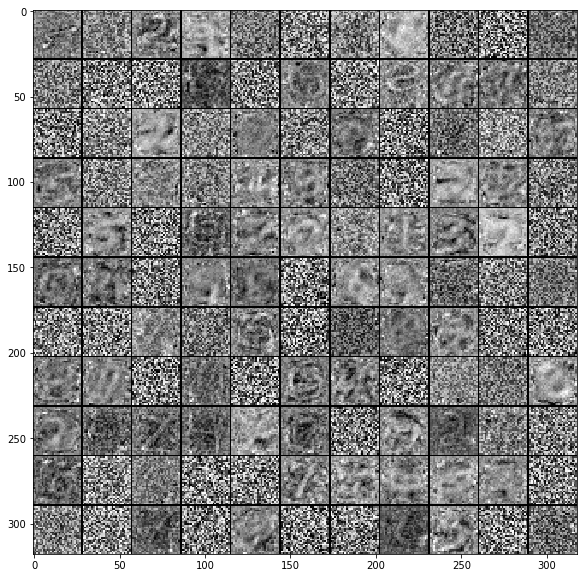

In [50]:
# Plot weights from first layer

# Obtain weight matrix
with tf.variable_scope("vae_enc_0", reuse=True):
    W_0 = tf.get_variable("W", dtype=TF_DTYPE)
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    W_0 = W_0.eval()

# Plot weights
W_0 = np.transpose(W_0)
image = Image.fromarray(
    plotting.tile_images(W_0, image_shape=(28, 28), tile_shape=(11, 11))
    )
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap="gray");

In [51]:
# Embed test data
n_test = 1000
x_np = mnist.test.images[:n_test, :]
test_labels = mnist.test.labels[:n_test]
test_labels = np.argmax(test_labels, axis=1)  # convert from one-hot
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    z_np = session.run([z_mean], feed_dict={x: x_np})[0]
    y_np = session.run([y], feed_dict={x: x_np})[0]

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/vae.ckpt


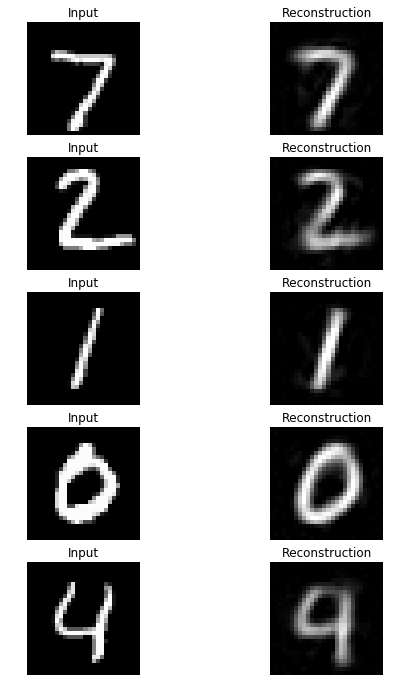

In [52]:
# Plot reconstruction
plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.title("Input")
    plt.imshow(x_np[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    plt.subplot(5, 2, 2*i + 2)
    plt.title("Reconstruction")
    plt.imshow(y_np[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")

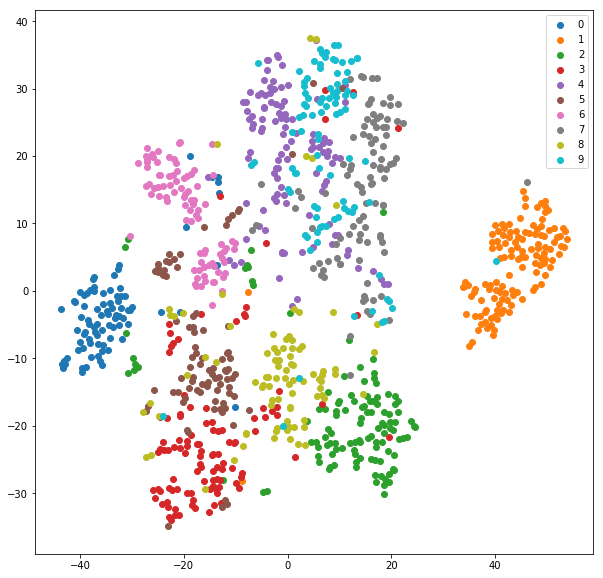

In [53]:
# Plot t-SNE embeddings of the latent variables
tsne = manifold.TSNE(
    n_components=2, #perplexity=20, init="random",
    random_state=0
    )
z_tsne = tsne.fit_transform(z_np)
plt.figure(figsize=(10, 10))
plot_labelled_2d_data(z_tsne, test_labels)
plt.legend();

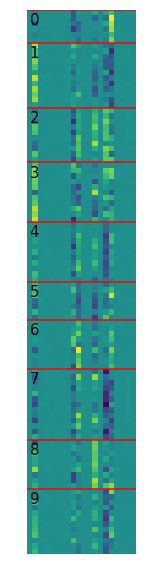

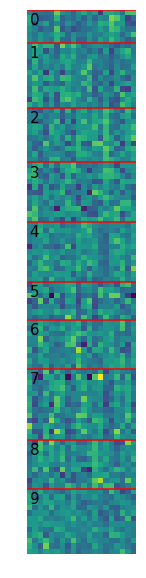

In [54]:
# Plot the embeddings themselves

# Get random indices
n_plot = 100
indices = np.arange(len(test_labels))
np.random.seed(1)
np.random.shuffle(indices)
indices = indices[:n_plot]

# Plot embeddings directly
indices_sorted = np.argsort(test_labels[indices], axis=0)
z_sorted = z_np[indices][indices_sorted, :]
labels_sorted = test_labels[indices][indices_sorted]
plt.figure(figsize=(10, 10))
plt.imshow(z_sorted)
ax = plt.gca()
for i, label in enumerate(labels_sorted):
    if labels_sorted[i] != labels_sorted[i - 1]:
        plt.axhline(y = i - 0.5, color="r")
        ax.text(0, i, str(label), verticalalignment="top", fontsize=15)
plt.axis('off');

# Plot mean and variance normalised embeddings
plt.figure(figsize=(10, 10))
plt.imshow(preprocessing.scale(z_sorted))
ax = plt.gca()
for i, label in enumerate(labels_sorted):
    if labels_sorted[i] != labels_sorted[i - 1]:
        plt.axhline(y = i - 0.5, color="r")
        ax.text(0, i, str(label), verticalalignment="top", fontsize=15)
plt.axis('off');

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/vae.ckpt


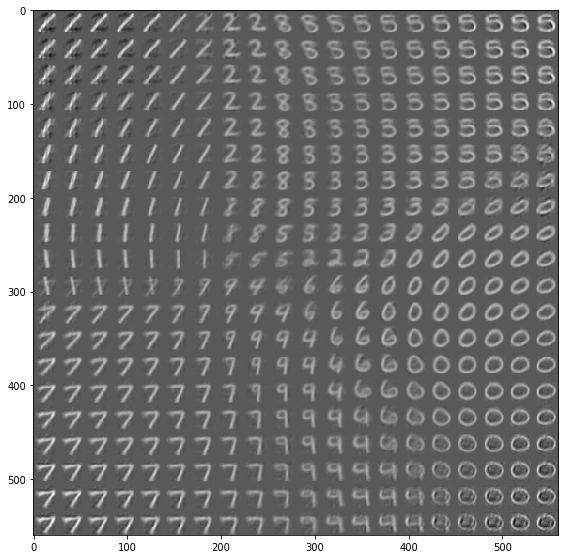

In [47]:
# Generate from latent space

# To do this, the above model needs to be trained with `n_z = 2`

def generate(z_given):
    with tf.Session() as session:
        saver.restore(session, model_fn)
        y_np = session.run([y], feed_dict={z: z_given})[0]
    return y_np

nx = ny = 20
M = 3
x_values = np.linspace(-M, M, nx)
y_values = np.linspace(-M, M, ny)

canvas = np.empty((28*ny, 28*nx))
z_means = []
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mean = np.array([xi, yi])
        z_means.append(z_mean)

x_means = generate(z_means)

x_means = list(x_means)
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        x_mean = x_means.pop(0)
        canvas[(nx - i - 1)*28:(nx - i)*28, j*28:(j + 1)*28] = x_mean.reshape(28, 28)

plt.figure(figsize=(8, 10))
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

## Vector-quantised variational autoencoder

_Resources:_ https://arxiv.org/abs/1711.00937; https://avdnoord.github.io/homepage/vqvae/; https://github.com/hiwonjoon/tf-vqvae; https://github.com/Kyubyong/vq-vae

The vector-quantised variational autoencoder (VQ-VAE) is trained with the following loss:

$$\ell(\vec{x}^{(i)}; \vec{\theta}) = -\log p(\vec{x}^{(i)}|\vec{z}_q) + \left|\left| \textrm{sg}\left[ \vec{z}_e \right] - \vec{e} \right|\right|^2 + \beta \left|\left| \vec{z}_e - \textrm{sg} \left[ \vec{e} \right] \right|\right|^2$$

with $\textrm{sg}(\cdot)$ denoting the _stop gradient_ operation. The vectors $\vec{z}_e$ and $\vec{z}_q$ are both calculated based on $\vec{x}^{(i)}$; $\vec{z}_e$ can be seen as an embedding of $\vec{x}^{(i)}$ according to the encoder, with $\vec{z}_q$ the quantised version of the embedding $\vec{z}_e$:

$$\vec{z}_q(\vec{x}^{(i)}) = \vec{e}_k \text{ with } k = \textrm{argmin}_j \left|\left| \vec{z}_e (\vec{x}^{(i)}) - \vec{e}_j \right|\right|$$

I.e., $\vec{z}_e$ is mapped to its closest embedding $\vec{e}_k$ in our dictionary of embedding vectors, giving the quantised encoder output $\vec{z}_q$.  In the loss above, $\vec{e} = \vec{z}_q(\vec{x}^{(i)})$, but I keep with the notation of the paper; this emphasises that the embeddings are directly updated.

The $\log p_{\theta}(\vec{x}^{(i)}|\vec{z}^{(l)})$ term in the loss is calculated as for the standard VAE.

In [55]:
def build_vq(x, K, D):
    """
    A vector quantisation layer with `K` components of dimensionality `D`.
    
    See https://github.com/hiwonjoon/tf-vqvae/blob/master/model.py.
    """
    
    # Embeddings
    embeds = tf.get_variable(
        "embeds", [K, D], dtype=TF_DTYPE,
        initializer=tf.contrib.layers.xavier_initializer()
        )
    
    # Quantise inputs
    embeds_tiled = tf.reshape(embeds, [1, K, D])  # [batch_size, K, D]
    x_tiled = tf.tile(tf.expand_dims(x, -2), [1, K, 1])
    dist = tf.norm(x_tiled - embeds_tiled, axis=-1)
    k = tf.argmin(dist, axis=-1)
    z_q = tf.gather(embeds, k)
    
    return {"embeds": embeds, "z_q": z_q}


def build_vqvae(x, enc_n_hiddens, n_z, dec_n_hiddens, K,
        activation=tf.nn.relu):
    """
    Build a VQ-VAE with `K` components.
    
    Parameters
    ----------
    The number of encoder and decoder units are given as lists. The embeddings
    have dimensionality `n_z`. The final layer is linear.

    Return
    ------
    A dictionary with the embeddings, the embedded output `z_e` from the
    encoder, the quantised output `z_q` from the encoder, and the final output
    `y` from the decoder.
    """
    
    # Encoder
    with tf.variable_scope("vqvae_enc"):
        for i_layer, n_hidden in enumerate(enc_n_hiddens):
            with tf.variable_scope("enc_{}".format(i_layer)):
                x = build_linear(x, n_hidden)
                x = activation(x)
        with tf.variable_scope("enc_{}".format(i_layer + 1)):
            z_e = build_linear(x, n_z)
    
    # Quantisation
    with tf.variable_scope("vqvae_quantise"):
        vq = build_vq(z_e, K, n_z)
        embeds = vq["embeds"]
        z_q = vq["z_q"]

    # Decoder
    x = z_q
    with tf.variable_scope("vqvae_dec"):
        for i_layer, n_hidden in enumerate(dec_n_hiddens):
            with tf.variable_scope("dec_{}".format(i_layer)):
                x = build_linear(x, n_hidden)
                if i_layer != len(dec_n_hiddens) - 1:
                    x = activation(x)
    y = x

    return {"embeds": embeds, "z_e": z_e, "z_q": z_q, "y": y}


def vqvae_loss(x, z_e, z_q, embeds, y, learning_rate=0.001, beta=0.25,
        sigma_sq=0.5):
    """
    Return the different loss components and the training operation.
    
    If `sigma_sq` is "bernoulli", then p(x|z) is assumed to be a Bernoulli
    distribution.
    """

    # Losses
    if sigma_sq == "bernoulli":
        recon_loss = tf.reduce_mean(
            -tf.reduce_sum(x*tf.log(1e-10 + y) + (1 - x)*tf.log(1e-10 + 1 - y),
            1)
            )
    else:
        recon_loss = 1./(2*sigma_sq)*tf.losses.mean_squared_error(x, y)
    vq_loss = tf.reduce_mean(
        tf.norm(tf.stop_gradient(z_e) - z_q, axis=-1)**2
        )
    commit_loss = tf.reduce_mean(
        tf.norm(z_e - tf.stop_gradient(z_q), axis=-1)**2
        )
    loss = recon_loss + vq_loss + beta*commit_loss
    
    # Backpropagation: Copy gradients for quantisation
    with tf.variable_scope("backward"):
        
        # Decoder gradients
        decoder_vars = tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES, "vqvae_dec"
            )
        decoder_grads = list(
            zip(tf.gradients(loss, decoder_vars), decoder_vars)
            )
        
        # Encoder gradients
        encoder_vars = tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES, "vqvae_enc"
            )
        z_q_grad = tf.gradients(recon_loss, z_q)
        encoder_grads = [
            (tf.gradients(z_e, var, z_q_grad)[0] +
            beta*tf.gradients(commit_loss, var)[0], var) for var in
            encoder_vars
            ]
        
        # Quantisation gradients
        embeds_grads = list(zip(tf.gradients(vq_loss, embeds), [embeds]))
        
        # Optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate)
        train_op = optimizer.apply_gradients(
            decoder_grads + encoder_grads + embeds_grads
            )

    return loss, recon_loss, vq_loss, commit_loss, train_op



In [56]:
# Test `build_vq`

import numpy.testing as npt

tf.reset_default_graph()

# Build test model
D = 5
K = 3
x = tf.placeholder(TF_DTYPE, [None, D])
with tf.variable_scope("test_vq"):
    vq = build_vq(x, K, D)
    embeds = vq["embeds"]
    z_q = vq["z_q"]

# Data
x_test_data = np.random.randn(4, D)

# Run model
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)
    embeds_np = embeds.eval()
    z_q_tf = session.run(z_q, feed_dict={x: x_test_data})
    
# NumPy equivalent
z_q_np = []
for x_test in x_test_data:
    dists = []
    for embed in embeds_np:
        dists.append(np.linalg.norm(x_test - embed))
    z_q_np.append(embeds_np[np.argmin(dists)])
z_q_np = np.array(z_q_np)

if not npt.assert_almost_equal(z_q_np, z_q_tf):
    print("Test passed")

Test passed


In [57]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 25
batch_size = 100
enc_n_hiddens = [100]
n_z = 20
dec_n_hiddens = [100, 28*28]
K = 20

# Model
x = tf.placeholder(TF_DTYPE, [None, 28*28])
vqvae = build_vqvae(x, enc_n_hiddens, n_z, dec_n_hiddens, K)
embeds = vqvae["embeds"]
z_e = vqvae["z_e"]
z_q = vqvae["z_q"]
y = vqvae["y"]
model_fn = path.join(output_dir, "vqvae.ckpt")

# Loss (Gaussian)
sigma_sq = 0.001  # smaller values: care more about reconstruction
beta = 0.25
loss, recon_loss, vq_loss, commit_loss, train_op = vqvae_loss(
    x, z_e, z_q, embeds, y, learning_rate=learning_rate, sigma_sq=sigma_sq,
    beta=beta
    )

# # Loss (Bernoulli)
# sigma_sq = "bernoulli"
# beta = 0.25
# y = tf.nn.sigmoid(y)
# loss, recon_loss, vq_loss, commit_loss, train_op = vqvae_loss(
#     x, z_e, z_q, embeds, y, learning_rate=learning_rate, sigma_sq=sigma_sq,
#     beta=beta
#     )

In [58]:
record_dict = train_fixed_epochs(
    n_epochs, train_op, [loss, recon_loss, vq_loss], MNISTTrainFeedIterator(),
    [x, y], tf.losses.mean_squared_error(x, y), MNISTTestFeedIterator(),
    save_best_val_model_fn=model_fn
    )

2018-06-05 17:55:25.381579
Epoch 0:
0.873 sec, train loss: [ 89.13180542  47.60080719  33.2247963 ], val loss: 0.0560788 *
Epoch 1:
0.855 sec, train loss: [ 50.4131813   26.70467377  18.96681404], val loss: 0.0503963 *
Epoch 2:
0.836 sec, train loss: [ 50.32739258  25.04236031  20.22802734], val loss: 0.0487103 *
Epoch 3:
0.894 sec, train loss: [ 52.61493301  24.26260948  22.68186378], val loss: 0.0473568 *
Epoch 4:
0.806 sec, train loss: [ 54.29650879  23.83119011  24.37228203], val loss: 0.0468925 *
Epoch 5:
0.852 sec, train loss: [ 54.23752213  23.69047928  24.43762589], val loss: 0.0464993 *
Epoch 6:
0.807 sec, train loss: [ 54.2781105   23.54575157  24.58587837], val loss: 0.0463156 *
Epoch 7:
0.805 sec, train loss: [ 54.91810226  23.47791672  25.15216637], val loss: 0.0460833 *
Epoch 8:
0.812 sec, train loss: [ 54.88951874  23.47434807  25.13212967], val loss: 0.0461911
Epoch 9:
0.996 sec, train loss: [ 54.41337585  23.43272972  24.78448486], val loss: 0.0460516 *
Epoch 10:
0.809

In [59]:
# Embed test data
n_test = 1000
x_np = mnist.test.images[:n_test, :]
test_labels = mnist.test.labels[:n_test]
test_labels = np.argmax(test_labels, axis=1)  # convert from one-hot
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    embeds_np = embeds.eval()
    z_q_np = session.run([z_q], feed_dict={x: x_np})[0]
    z_e_np = session.run([z_e], feed_dict={x: x_np})[0]
    y_np = session.run([y], feed_dict={x: x_np})[0]

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/vqvae.ckpt


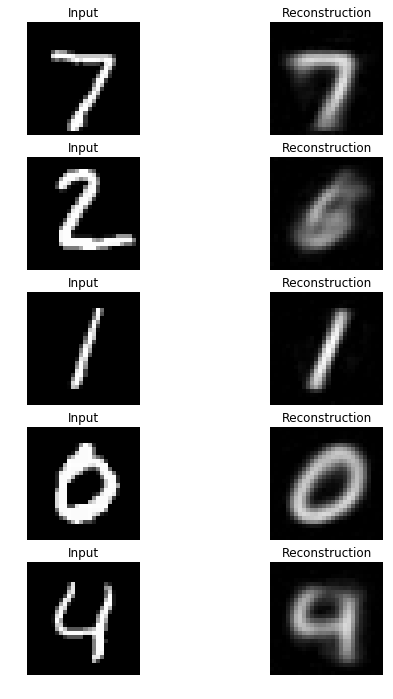

In [60]:
# Plot reconstruction
plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.title("Input")
    plt.imshow(x_np[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    plt.subplot(5, 2, 2*i + 2)
    plt.title("Reconstruction")
    plt.imshow(y_np[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/vqvae.ckpt


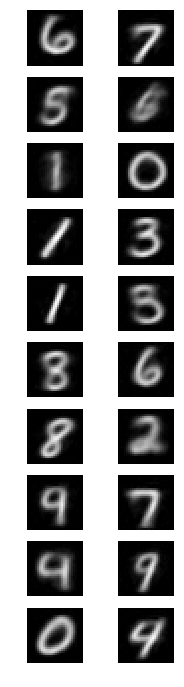

In [61]:
# Obtain templates
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    embeds_np = embeds.eval()
    y_embeds_np = session.run([y], feed_dict={z_q: embeds_np})[0]

# Plot templates
plt.figure(figsize=(3, 12))
for i in range(K):
    plt.subplot(K/2, 2, i + 1)
    plt.imshow(y_embeds_np[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")

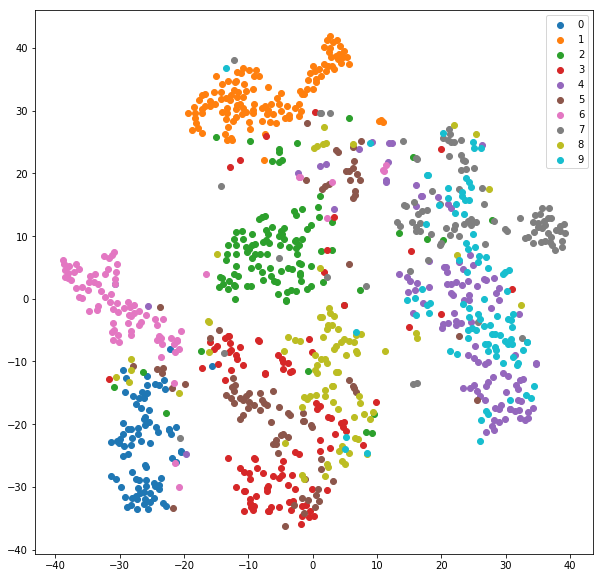

In [62]:
# Plot t-SNE embeddings of the latent variables
tsne = manifold.TSNE(
    n_components=2, #perplexity=20, init="random",
    random_state=0
    )
z_tsne = tsne.fit_transform(z_e_np)
plt.figure(figsize=(10, 10))
plot_labelled_2d_data(z_tsne, test_labels)
plt.legend();

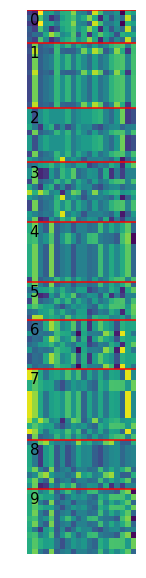

In [63]:
# Plot the embeddings themselves

# Get random indices
n_plot = 100
indices = np.arange(len(test_labels))
np.random.seed(1)
np.random.shuffle(indices)
indices = indices[:n_plot]

# Plot embeddings directly
indices_sorted = np.argsort(test_labels[indices], axis=0)
z_sorted = z_q_np[indices][indices_sorted, :]
labels_sorted = test_labels[indices][indices_sorted]
plt.figure(figsize=(10, 10))
plt.imshow(z_sorted)
ax = plt.gca()
for i, label in enumerate(labels_sorted):
    if labels_sorted[i] != labels_sorted[i - 1]:
        plt.axhline(y = i - 0.5, color="r")
        ax.text(0, i, str(label), verticalalignment="top", fontsize=15)
plt.axis('off');

## Categorical VAE using the Gumbel-Softmax trick

_Resources:_ https://arxiv.org/abs/1611.01144; https://arxiv.org/abs/1611.00712; https://blog.evjang.com/2016/11/tutorial-categorical-variational.html; https://github.com/ericjang/gumbel-softmax

As in the standard VAE, we train by minimising the negative ELBO, i.e. by maximising the ELBO:

$$\log p_\theta(\vec{x}^{(i)}) \geq \mathbb{E}_{q_{\phi}(\vec{z}|\vec{x}^{(i)})} \left[ \log p_{\theta}(\vec{x}^{(i)}|\vec{z}) \right] - D_{\textrm{KL}} \left( q_{\phi}(\vec{z}|\vec{x}^{(i)}) || p(\vec{z}) \right)$$

However, where $q_{\phi}(\vec{z}|\vec{x}^{(i)})$ was a multivariate Gaussian distribution (i.e. a continuous vector), here it is specified by a Gumbel-Softmax distribution, with

$$ z_k = \frac{ \exp\left\{ (\log \pi_k + g_k) / \tau \right\} }{ \sum_{k = 1}^K \exp\left\{ (\log \pi_k + g_k) / \tau \right\} }$$

where $g_1, g_2, \ldots, g_K$ are i.i.d. samples from a $\textrm{Gumbel}(0, 1)$ distribution and $\tau$ is a temperature parameter.  This distribution approximates a categorical distribution with $K$ categories.  As the temperature $\tau \rightarrow 0$, the Gumbel-Softmax becomes identical to the categorical distribution with (unnormalised) component weights $\{ \pi_j \}_{k = 1}^K = \vec{\pi}$.  In the forward pass, $\log\vec{\pi}$ is given as the output of the encoder based on network input $\vec{x}^{(i)}$.

The first term in the loss---which I calll the _reconstruction term_---is handled exactly as in the VAE.  I.e., it is usally approximeted by using a single Monte Carlo sample.

For the second term in the loss---the KL divergence---we make an approximation.  Instead of using the distribution for $q_{\phi}(\vec{z}|\vec{x}^{(i)})$ directly (as specified above), we just assume that it is categorical.  We use a uniform prior for $\vec{z}$, i.e. $p(z = k) = \frac{1}{K}$.  The KL divergence is then simply between two categorical distributions, one with mass given by $\vec{\pi}$ and the other with equal mass $\frac{1}{K}$:

$$ D_{\textrm{KL}} \left( q_{\phi}(\vec{z}|\vec{x}^{(i)}) || p(\vec{z}) \right) = -\sum_{k = 1}^K q_{\phi}(z = k|\vec{x}^{(i)}) \left( \log p(z = k) - \log q_{\phi}(z = k|\vec{x}^{(i)}) \right) $$

with $\log p(z = k) = \frac{1}{K}$ for all $k$ and $q_{\phi}(z = k|\vec{x}^{(i)}) = \pi_k$, the $k^\textrm{th}$ output from the encoder for input $\vec{x}^{(i)}$. (I overloaded the notation here slightly with $z = k$ referring to the event where element $k$ of $\vec{z}$ is set to $1$.)  Note that if $\log\vec{\pi}$ is unnormalised, it will have to be normalised (which can be accomplished in TensorFlow by passing it through a `softmax`).

In [64]:
# Code adapted from https://github.com/ericjang/gumbel-softmax/

def sample_gumbel(shape, eps=1e-20): 
    """Sample from Gumbel(0, 1) distribution."""
    U = tf.random_uniform(shape, minval=0, maxval=1)
    return -tf.log(-tf.log(U + eps) + eps)


def gumbel_softmax_sample(logits, temperature): 
    """Draw a sample from the Gumbel-Softmax distribution."""
    y = logits + sample_gumbel(tf.shape(logits))
    return tf.nn.softmax(y/temperature)


def gumbel_softmax(logits, temperature, hard=False):
    """
    Sample from the Gumbel-Softmax distribution and optionally discretise.
    """
    y = gumbel_softmax_sample(logits, temperature)
    if hard:
        k = tf.shape(logits)[-1]
        y_hard = tf.cast(
            tf.equal(y, tf.reduce_max(y, 1, keep_dims=True)), y.dtype
            )
        y = tf.stop_gradient(y_hard - y) + y
    return y


def build_catvae(x, enc_n_hiddens, dec_n_hiddens, K, N, activation=tf.nn.relu):
    """
    Build a categorical VAE with `N` distributions each with `K` components.

    Parameters
    ----------
    The number of encoder and decoder units are given as lists.

    Return
    ------
    A dictionary with the log of the categorical distribution based directly on
    the logits `log_logits_categorical`, the one-hot latent variable output `z`
    from the encoder, the final output `y` from the decoder, and the temperate
    variable `tau`.
    """

    tau = tf.placeholder(TF_DTYPE, [])
    
    # Encoder
    for i_layer, n_hidden in enumerate(enc_n_hiddens):
        with tf.variable_scope("catvae_enc_{}".format(i_layer)):
            x = build_linear(x, n_hidden)
            x = activation(x)

    # Latent variable
    with tf.variable_scope("catvae_latent"):
        logits = build_linear(x, K*N)  # the log(pi_i)'s  # log_pis
        softmax_logits = tf.nn.softmax(logits)
        log_logits_categorical = tf.log(softmax_logits + 1e-20)
        z = tf.reshape(gumbel_softmax(logits, tau, hard=False), [-1, N, K])

    # Decoder
    x = tf.reshape(z, [-1, N*K])
    for i_layer, n_hidden in enumerate(dec_n_hiddens):
        with tf.variable_scope("catvae_dec_{}".format(i_layer)):
            x = build_linear(x, n_hidden)
            if i_layer != len(dec_n_hiddens) - 1:
                x = activation(x)
    y = x
    
    return {
        "softmax_logits": softmax_logits, "log_logits_categorical":
        log_logits_categorical, "z": z, "y": y, "tau": tau
        }


In [65]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 50
batch_size = 100
enc_n_hiddens = [500, 500]
dec_n_hiddens = [500, 500, 28*28]
K = 20
N = 1

# Model
x = tf.placeholder(TF_DTYPE, [None, 28*28])
catvae = build_catvae(x, enc_n_hiddens, dec_n_hiddens, K, N)
softmax_logits = catvae["softmax_logits"]
log_logits_categorical = catvae["log_logits_categorical"]
z = catvae["z"]
y = catvae["y"]
tau = catvae["tau"]
model_fn = path.join(output_dir, "catvae.ckpt")

# Temperature
tau_init = 1.0
anneal_rate = 0.03
tau_min = 0.5

# Loss (KL divergence)
kl_tmp = tf.reshape(softmax_logits*(log_logits_categorical - tf.log(1.0/K)), [-1, N, K])
kl = tf.reduce_sum(kl_tmp, [1, 2])

# Loss (Gaussian)
sigma_sq = 0.001
loss = 1./(2*sigma_sq)*tf.losses.mean_squared_error(x, y) + tf.reduce_mean(kl)

# # Loss (Bernoulli)
# y = tf.nn.sigmoid(y)
# loss = tf.reduce_mean(
#     -tf.reduce_sum(x*tf.log(1e-10 + y) + (1 - x)*tf.log(1e-10 + 1 - y), 1)
#     ) + tf.reduce_mean(kl)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [66]:
# Train model

class MNISTTrainFeedIterator(object):
    i_epoch = 0
    def __iter__(self):
        cur_tau = np.maximum(
            tau_init*np.exp(-anneal_rate*MNISTTrainFeedIterator.i_epoch), tau_min
            )
        MNISTTrainFeedIterator.i_epoch += 1
        n_batches = int(mnist.train.num_examples/batch_size)
        for i_batch in xrange(n_batches):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            yield [batch_x, cur_tau]

class MNISTTestFeedIterator(object):
    def __iter__(self):
        yield [mnist.test.images, tau_min]

record_dict = train_fixed_epochs(
    n_epochs, optimizer,  [loss, tau], MNISTTrainFeedIterator(),
    [x, tau],loss, MNISTTestFeedIterator(),
    save_model_fn=model_fn
    )

2018-06-05 17:56:30.586940
Epoch 0:
1.048 sec, train loss: [ 38.6938324   1.       ], val loss: 32.5231
Epoch 1:
0.976 sec, train loss: [ 30.52276611   0.97045177], val loss: 29.658
Epoch 2:
0.952 sec, train loss: [ 27.35771751   0.9417668 ], val loss: 26.7306
Epoch 3:
0.950 sec, train loss: [ 25.16334152   0.91393447], val loss: 25.6885
Epoch 4:
0.970 sec, train loss: [ 24.3143158    0.88692486], val loss: 25.0983
Epoch 5:
0.995 sec, train loss: [ 23.80462074   0.86071116], val loss: 24.9412
Epoch 6:
0.940 sec, train loss: [ 23.369627     0.83526772], val loss: 24.4236
Epoch 7:
1.000 sec, train loss: [ 22.99311829   0.81057954], val loss: 24.0301
Epoch 8:
1.016 sec, train loss: [ 22.6757679   0.7866233], val loss: 23.9941
Epoch 9:
1.033 sec, train loss: [ 22.41781807   0.76337552], val loss: 23.6239
Epoch 10:
1.012 sec, train loss: [ 22.15262794   0.74081606], val loss: 23.3279
Epoch 11:
0.991 sec, train loss: [ 21.9585743    0.71892554], val loss: 23.2146
Epoch 12:
1.007 sec, train l

In [67]:
# Embed test data
n_test = 1000
x_np = mnist.test.images[:n_test, :]
test_labels = mnist.test.labels[:n_test]
test_labels = np.argmax(test_labels, axis=1)  # convert from one-hot
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    z_np = session.run([z], feed_dict={x: x_np, tau: 0.05})[0]
    y_np = session.run([y], feed_dict={x: x_np, tau: 0.05})[0]

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/catvae.ckpt


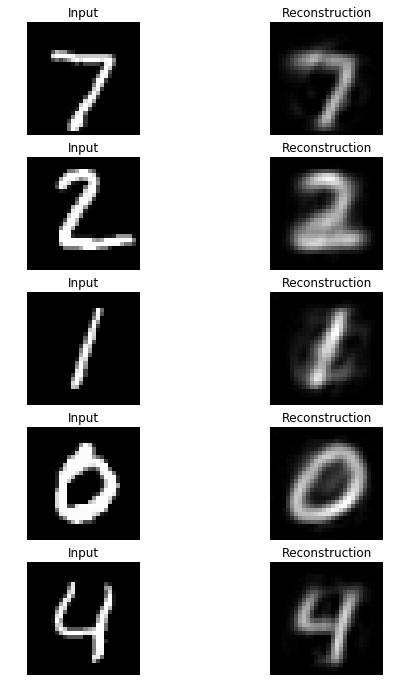

In [68]:
# Plot reconstruction
plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.title("Input")
    plt.imshow(x_np[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    plt.subplot(5, 2, 2*i + 2)
    plt.title("Reconstruction")
    plt.imshow(y_np[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")

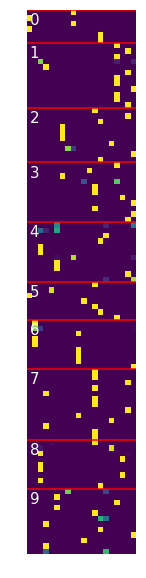

In [70]:
# Plot the embeddings themselves

# Get random indices
n_plot = 100
indices = np.arange(len(test_labels))
np.random.seed(1)
np.random.shuffle(indices)
indices = indices[:n_plot]

# Plot embeddings directly
indices_sorted = np.argsort(test_labels[indices], axis=0)
z_sorted = np.reshape(z_np, [n_test, -1])[indices][indices_sorted, :]
labels_sorted = test_labels[indices][indices_sorted]
plt.figure(figsize=(10, 10))
plt.imshow(z_sorted)
ax = plt.gca()
for i, label in enumerate(labels_sorted):
    if labels_sorted[i] != labels_sorted[i - 1]:
        plt.axhline(y = i - 0.5, color="r")
        ax.text(0, i, str(label), verticalalignment="top", fontsize=15, color="w")
plt.axis('off');